In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
import numpy as np
from PIL import Image
import cv2
from tensorflow.keras.utils import plot_model

# Это наша метрика на Tensorflow

def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [3]:
# Подключаем google диск
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [4]:
# Сканируем каталоги с изображениями и метками
import os, fnmatch
imag = os.listdir('/gdrive/My Drive/app/images')
imag_label = os.listdir('/gdrive/My Drive/app/labels')

In [5]:
PAHT_label = '/gdrive/My Drive/app/labels/'
PAHT_image = '/gdrive/My Drive/app/images/'

In [6]:
# Затисался лишний файл, убираем его
imag = imag[:-1]

In [ ]:
imag,imag_label

(['00_002600.png',
  '00_002400.png',
  '00_002000.png',
  '00_001600.png',
  '00_002800.png',
  '00_000400.png',
  '00_001400.png',
  '00_000800.png',
  '00_001800.png',
  '00_003200.png',
  '00_000600.png',
  '00_000200.png',
  '00_001000.png',
  '00_001200.png',
  '00_003000.png',
  '00_002200.png',
  '00_003400.png'],
 ['00_001600.png',
  '00_001200.png',
  '00_000200.png',
  '00_000600.png',
  '00_003400.png',
  '00_003000.png',
  '00_002000.png',
  '00_003200.png',
  '00_000400.png',
  '00_001400.png',
  '00_002800.png',
  '00_000800.png',
  '00_001000.png',
  '00_002200.png',
  '00_001800.png',
  '00_002600.png',
  '00_002400.png'])

In [7]:
# Загружаем картинку и меняем ее размер
images = []
segments = []
image_size = (400,1200)
for i_name in imag:
  images.append(image.load_img(PAHT_image+i_name ,target_size=image_size))
  segments.append(image.load_img(PAHT_label+i_name, target_size=image_size))

In [8]:
# Преобразуем изображения в массив данных
xTrain_Test = []

for img in images:
  x = image.img_to_array(img)
  xTrain_Test.append(x)

xTrain_Test = np.array(xTrain_Test)

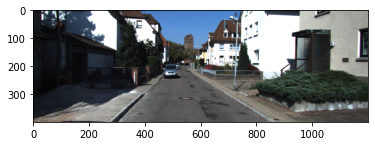

In [9]:
plt.imshow(images[0].convert('RGBA'))
plt.show()

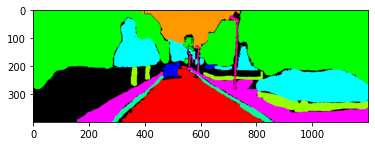

In [14]:
plt.imshow(segments[0].convert('RGBA'))
plt.show()

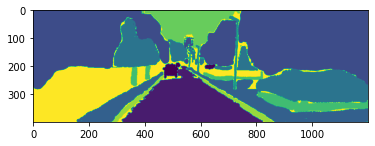

In [10]:
# Делаем конвертер в one-hot_encoding для выходных примеров
def Color2index(y):
  arr_col=[[0,0,255],[255,0,0],[255,255,0],[0,255,0],[255,0,255],[0,255,255],[255,0,153],[153,0,255],[0,153,255],[153,255,0],[255,153,0],[0,255,153],[0,153,153],[0,0,0]]
  y_ind = np.zeros((y.shape[0],y.shape[1]))
  y_cat = np.zeros((y.shape[0],y.shape[1], len(arr_col)))
  i = 1
  for i_color in arr_col:
    ind_i = np.where((y[:,:,0]==i_color[0])&(y[:,:,1]==i_color[1])&(y[:,:,2]==i_color[2]))
    y_ind[ind_i[0],ind_i[1]] = i
    y_cat[ind_i[0],ind_i[1], i-1] = 1 
    i += 1
  
  return y_cat, y_ind, i-1
cat_yi,ind_yi,h = Color2index(image.img_to_array(segments[0]))
plt.imshow(ind_yi.astype(float)/h)
plt.show()  


In [11]:
yTrain_Test = []

for seg in segments:
  y_cat,_,_ = Color2index(image.img_to_array(seg))
  yTrain_Test.append(y_cat)

yTrain_Test = np.array(yTrain_Test)

In [12]:
print(xTrain_Test.shape)
print(yTrain_Test.shape)

(17, 400, 1200, 3)
(17, 400, 1200, 14)


In [13]:
N = 15
yTrain = yTrain_Test[:N,:,:,:]
xTrain = xTrain_Test[:N,:,:,:]

yTest = yTrain_Test[N:,:,:,:]
xTest = xTrain_Test[N:,:,:,:]

In [14]:
print(xTrain.shape)
print(yTrain.shape)

(15, 400, 1200, 3)
(15, 400, 1200, 14)


Создаём и обучаем U-net

In [21]:
def cuttedUnet(num_classes = 14, input_shape= (200, 600, 3)):
    img_input = Input(input_shape)

    # Block 1
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_1_out = Activation('relu')(x)
    
    x = MaxPooling2D()(block_1_out)
    # print(x.shape, block_1_out.shape)
    # Block 2
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_2_out = Activation('relu')(x)

    x = MaxPooling2D()(block_2_out)
    # print(x.shape, block_2_out.shape)
    # Block 3
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_3_out = Activation('relu')(x)

    x = MaxPooling2D()(block_3_out)
    # print(x.shape, block_3_out.shape)
    # Block 4
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
    x = BatchNormalization()(x)
    # запомним тензор для переноса
    block_4_out = Activation('relu')(x)

    # x = MaxPooling2D()(block_4_out)

    # Block 5
    # x = Conv2D(512, (3, 3), padding='same', name='block5_conv1')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # x = Conv2D(512, (3, 3), padding='same', name='block5_conv2')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # x = Conv2D(512, (3, 3), padding='same', name='block5_conv3')(x)
    # x = BatchNormalization()(x)
    # block_5_out = Activation('relu')(x)

    # UP 1
    # x = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # x = concatenate([x, block_4_out])
    # x = Conv2D(512, (3, 3), padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)
 
    # x = Conv2D(512, (3, 3), padding='same')(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # UP 2
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_3_out])
    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 3
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_2_out])
    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # UP 4
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # добавили перенос из понижаюшего плеча
    x = concatenate([x, block_1_out])
    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # слой классификатор
    x = Conv2D(num_classes, (3, 3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(),
                  loss='categorical_crossentropy',
                  metrics=[dice_coef])
    model.summary()
    return model

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 400, 1200, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 400, 1200, 64 1792        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, 400, 1200, 64 256         block1_conv1[0][0]               
__________________________________________________________________________________________________
activation_44 (Activation)      (None, 400, 1200, 64 0           batch_normalization_44[0][0]     
____________________________________________________________________________________________

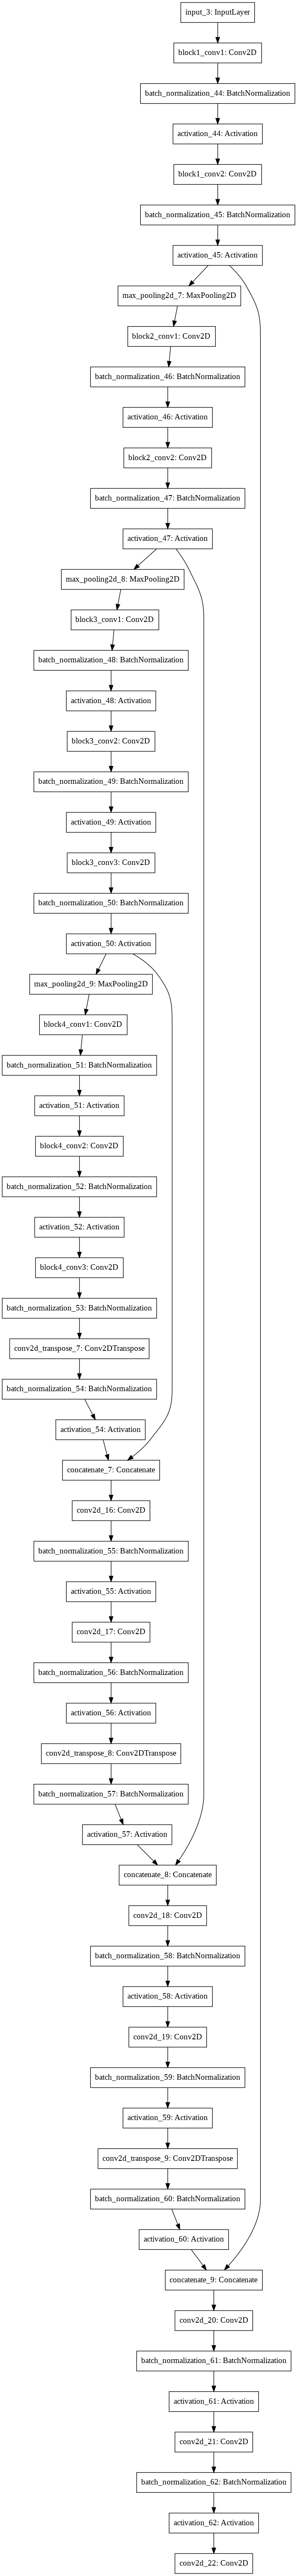

In [27]:
modelC = cuttedUnet(14, (400, 1200, 3))

plot_model(modelC, to_file='modelC.png')

In [28]:
history = modelC.fit(xTrain, yTrain, epochs=50, batch_size=3, validation_data=(xTrain, yTrain))

Epoch 1/50
5/5 [==============================] - 21s 4s/step - loss: 2.1993 - dice_coef: 0.1879 - val_loss: 9.3345 - val_dice_coef: 0.2703
Epoch 2/50
5/5 [==============================] - 20s 4s/step - loss: 1.6304 - dice_coef: 0.3234 - val_loss: 11.1767 - val_dice_coef: 0.3051
Epoch 3/50
5/5 [==============================] - 20s 4s/step - loss: 1.4810 - dice_coef: 0.3757 - val_loss: 11.1775 - val_dice_coef: 0.3038
Epoch 4/50
5/5 [==============================] - 20s 4s/step - loss: 1.3970 - dice_coef: 0.3937 - val_loss: 11.1671 - val_dice_coef: 0.3042
Epoch 5/50
5/5 [==============================] - 20s 4s/step - loss: 1.3409 - dice_coef: 0.3990 - val_loss: 11.1312 - val_dice_coef: 0.3050
Epoch 6/50
5/5 [==============================] - 20s 4s/step - loss: 1.2913 - dice_coef: 0.4142 - val_loss: 11.1780 - val_dice_coef: 0.3057
Epoch 7/50
5/5 [==============================] - 20s 4s/step - loss: 1.2838 - dice_coef: 0.4203 - val_loss: 11.1746 - val_dice_coef: 0.3059
Epoch 8/50
5/5

In [29]:
pred = modelC.predict(xTest)
print(pred.shape)

(2, 400, 1200, 14)


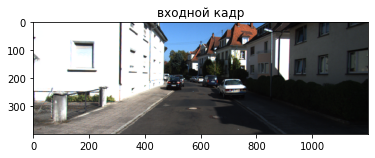

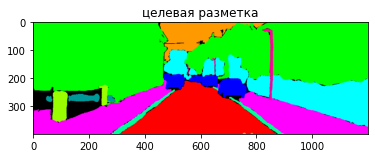

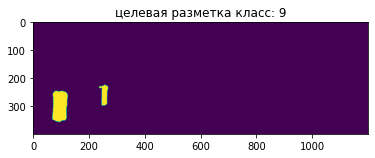

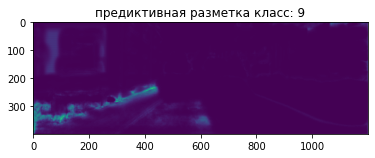

In [39]:
n = 0
class_ =9
plt.imshow(images[N+n].convert('RGBA'))
plt.title('входной кадр')
plt.show()
plt.imshow(segments[N+n].convert('RGBA'))
plt.title('целевая разметка')
plt.show()
img = yTest[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('целевая разметка класс: '+str(class_))
plt.show()
img = pred[n][:,:,class_]
plt.imshow(img.astype(float))
plt.title('предиктивная разметка класс: '+str(class_))
plt.show()

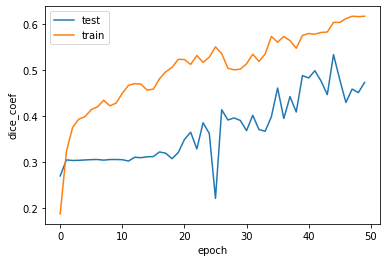

In [31]:
plt.plot(history.history['val_dice_coef'],label = 'test')
plt.plot(history.history['dice_coef'],label='train')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('dice_coef')
plt.show()

Было построено несколько сетей, которые показали следующие результаты:
1. Размер изображения 200*600, 30 эпох, 3 сверточных слоя, результат - val_loss: 1.8885 - val_dice_coef: 0.4525;
2. Размер изображения 400*1200, 30 эпох, 3 сверточных слоя, результат - val_loss: 3.4914 - val_dice_coef: 0.3652;
3. Размер изображения 400*1200, 30 эпох, 4 сверточных слоя, результат - val_loss: 14.2517 - val_dice_coef: 0.1102;
4. Размер изображения 400*1200, 50 эпох, 3 сверточных слоя, результат - val_loss: 2.0702 - val_dice_coef: 0.4733.

Лучшие результаты показала 4 сеть. Увеличение размер изображения привело к снижению качества сети, логичным было предположить, что улучшить качество модели поможет дополнительный сверточный слой, но при его добавлении качество сети стало еще хуже. Улучшить сеть помогло увеличени количества эпох т.к. при предыдущих построениях было видно, что сеть не дообучена. Однако взятое мной количество эпох (50), оказалось больше оптимального модель стала переобучаться. Дополнительно хочу отметить, что если для 1 сети увеличить количество эпох скорее всего она покажет результаты лучше чем у 4 сети. Так же следует отметить, что измеренные показатели и их соотношение не совсем коректные т.к. каждая сеть обучалась по 1 разу, для более достоверных результатов необходимо было обучть каждую сеть хотябы раз 5, а лучше 10 и усреднить полученные результаты.